# TP Module 5 : Personnaliser son réseau de neurones

In [0]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

# Splitting
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

2.2.0
2.3.0-tf


In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten

In [0]:
!nvidia-smi

Mon May 18 12:33:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Dataset

In [0]:
(X_train,y_train), (X_test,y_test)  = tf.keras.datasets.cifar100.load_data()

print(X_train.shape, y_train.shape)

169009152/169001437 [==============================] - 5s 0us/step
(50000, 32, 32, 3) (50000, 1)


In [0]:
X_train = X_train.reshape(-1, 32, 32, 3).astype('float32')
X_test = X_test.reshape(-1, 32, 32, 3).astype('float32')


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=RANDOM_SEED)

X_test = X_test/255
X_train = X_train/255
X_valid = X_valid/255

y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=100)
y_valid_oh = tf.keras.utils.to_categorical(y_valid, num_classes=100)

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    #image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    #image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

def create_train_dataset(features, labels, batch=64, repet=1, prefetch=1):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
    dataset = dataset.repeat(repet)
    dataset = dataset.map(train_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(prefetch)
    return dataset

def create_test_dataset(features, labels, batch=64, repet=1, prefetch=1):
    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.shuffle(len(features), seed=RANDOM_SEED)
    dataset = dataset.repeat(repet)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(prefetch)
    return dataset

ds_train = create_train_dataset(X_train, y_train_oh)
ds_val = create_test_dataset(X_valid, y_valid_oh)
ds_test = create_test_dataset(X_test, y_test_oh)

## Les architectures modernes

In Convolutional Nets, there is no such thing as "fully-connected layers". There are only convolution layers with $1 \times 1$ convolution kernels and a full connection table.

It's a too-rarely-understood fact that ConvNets don't need to have a fixed-size input. You can train them on inputs that happen to produce a single output vector (with no spatial extent), and then apply them to larger images. Instead of a single output vector, you then get a spatial map of output vectors. Each vector sees input windows at different locations on the input.

In that scenario, the "fully connected layers" really act as $1 \times 1$ convolutions.

*Yann LeCun*

### ResNet

#### Idée

- Driven by the significance of depth, a question arises : *Is learning better networks as easy as stacking more layers ?* An obstacle to answering this question was the notorious problem of vanishing/exploding gradient [...]. This problem, however, has been largely addressed by normalized initilization and intermediate normalization layers. (ie BatchNorm et initialisation des poids)

- When deeper networks are able to start converging, a *degradation* problem has been exposed : : with the network depth increasing, accuracy gets saturated (...) and then degrades rapidly. **Unexpectedly, such a degradation is *not caused by overfitting*, and adding more layers to a suitably deep model leads to *higher training error***.

- We show that :
  1. Our extremely deep *residual nets* are esay to optimize, but the counterpart "plain" nets (that simply stacks layers) exhibit higher training error when the depth increases.
  2. Our deep residual nets can easily enjoy accuracy gains from greatly increased depth, producing results substantially better than previous networks.

- Our 152-layers residual net is the deeper network ever presented on ImageNet (2015), while still having lower complexity than VGG nets.

- The degradation problem suggests that the solvers (ie weights optimization) might have difficulties in approximating identity mappings by multiple nonlinear layers.

#### Définition des briques de bases

- We adopt batch normalization (BN) right after each convolution and before activation.

In [0]:
def conv_batchnorm_relu(x, filters, kernel_size, strides):
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=strides,
             padding='same',
             kernel_initializer="he_normal",
             use_bias = False)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  return x

##### Bloc Identité

- The three layers are $1 \times 1$, $3 \times 3$, and $1 \times 1$ convolutions, where the $1 \times 1$ layers are responsible for reducing and then increasing (restoring) dimensions, leaving the $3 \times 3$ layer a bottleneck with smaller input/output dimensions.

- $50$-layer ResNet: We replace each $2$-layer block in the $34$-layer net with this $3$-layer bottleneck block, resulting in a $50$-layer ResNet (Table 1). We use option B for increasing dimensions (ie projection blocks).

In [0]:
def identity_block(tensor, filters):
  x = conv_batchnorm_relu(tensor,
                          filters=filters,
                          kernel_size=1,
                          strides=1)
  #print(x.shape)
  x = conv_batchnorm_relu(x,
                          filters=filters,
                          kernel_size=3,
                          strides=1)
  #print(x.shape)
  x = Conv2D(filters=4*filters,
             kernel_size=1, 
             strides=1,
             kernel_initializer="he_normal")(x)  # notice: filters=4*filters
  #print(x.shape)
  x = BatchNormalization()(x)

  x = Add()([x, tensor])
  x = ReLU()(x)
  return x

##### Bloc Projection

- The projection shortcut in Eqn.(2) is used to match dimensions (done by $1 \times 1$ convolutions). For both options, when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2

- [...] Projection shortcuts are used for increasing dimensions, and other shortcuts are identity;

In [0]:
def projection_block(tensor, filters, strides):
  # left stream
  x = conv_batchnorm_relu(tensor, 
                          filters=filters, 
                          kernel_size=1,
                          strides=strides)
  x = conv_batchnorm_relu(x,
                          filters=filters,
                          kernel_size=3,
                          strides=1)
  x = Conv2D(filters=4*filters,
             kernel_size=1,
             strides=1,
             kernel_initializer="he_normal")(x)  # notice: filters=4*filters
  x = BatchNormalization()(x)

  # right stream
  shortcut = Conv2D(filters=4*filters,
                    kernel_size=1,
                    strides=strides,
                    kernel_initializer="he_normal")(tensor)  # notice: filters=4*filters
  shortcut = BatchNormalization()(shortcut)

  x = Add()([x, shortcut])
  x = ReLU()(x)
  return x

##### Bloc ResNet

- Donwsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2.

In [0]:
def resnet_block(x, filters, reps, strides):
  x = projection_block(x, filters=filters, strides=strides)
  for _ in range(reps-1):
    x = identity_block(x, filters=filters)
  return x

In [0]:
input = Input(shape=(32, 32, 3))

x = conv_batchnorm_relu(input, filters=64, kernel_size=7, strides=2)  # [3]: 7x7, 64, strides 2
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # [3]: 3x3 max pool, strides 2

x = resnet_block(x, filters=64, reps=3, strides=1)
x = resnet_block(x, filters=128, reps=4, strides=2)  # strides=2 ([2]: conv3_1)
x = resnet_block(x, filters=256, reps=6, strides=2)  # strides=2 ([2]: conv4_1)
x = resnet_block(x, filters=512, reps=3, strides=2)  # strides=2 ([2]: conv5_1)

x = GlobalAvgPool2D()(x)  # [3]: average pool *it is not written any pool size so we use Global
x = Dense(100)(x)
output = Activation('softmax')(x)  # [3]: 1000-d fc, softmax

from tensorflow.keras import Model

model = Model(input, output)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 16, 16, 64)   9408        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 16, 16, 64)   256         conv2d_167[0][0]                 
__________________________________________________________________________________________________
re_lu_152 (ReLU)                (None, 16, 16, 64)   0           batch_normalization_166[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [0]:
import time
start = time.time()
history = model.fit(ds_train,
                    epochs=20,
                    validation_data = ds_val)

print(f"It took {time.time() - start} seconds")

Epoch 1/20
1172/1172 [==============================] - 57s 49ms/step - loss: 0.9570 - accuracy: 0.6647 - val_loss: 1.0660 - val_accuracy: 0.6246
Epoch 2/20
1172/1172 [==============================] - 57s 48ms/step - loss: 0.9468 - accuracy: 0.6715 - val_loss: 0.9648 - val_accuracy: 0.6563
Epoch 3/20
1172/1172 [==============================] - 57s 48ms/step - loss: 0.9169 - accuracy: 0.6779 - val_loss: 0.9009 - val_accuracy: 0.6806
Epoch 4/20
1172/1172 [==============================] - 57s 48ms/step - loss: 0.8700 - accuracy: 0.6936 - val_loss: 0.9810 - val_accuracy: 0.6605
Epoch 5/20
1172/1172 [==============================] - 58s 49ms/step - loss: 0.8400 - accuracy: 0.7034 - val_loss: 1.0241 - val_accuracy: 0.6444
Epoch 6/20
1172/1172 [==============================] - 57s 49ms/step - loss: 0.8027 - accuracy: 0.7189 - val_loss: 0.9003 - val_accuracy: 0.6813
Epoch 7/20
1172/1172 [==============================] - 58s 49ms/step - loss: 0.7728 - accuracy: 0.7295 - val_loss: 1.0182 -

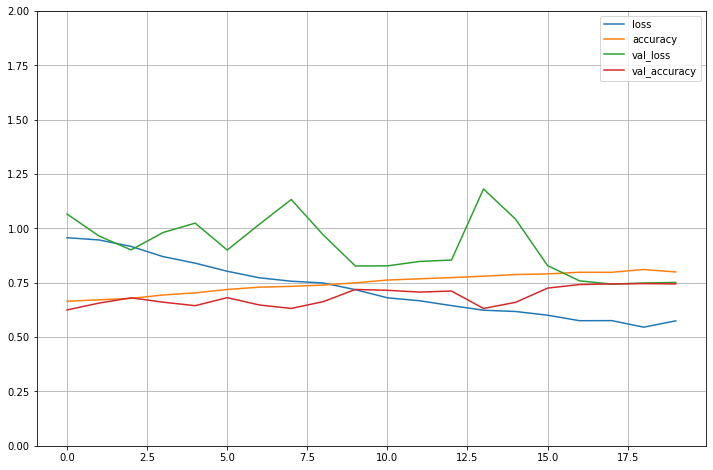

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

### DenseNet

#### Idée

- As CNNs become increasingly deep, a new research problem emerges : as 
information about the input of gradient passes through many layers, it can vanish and "wash out" by the time it reaches the end (or beginning) of the network.

- to ensure maximum information flow between layers in the network, we connect *all layers* (with matching feature maps sizes) directly with each other.

- Crucially, in contrast to ResNets, we never combine features through summation before they are passed into a layer, instead, we combine features by concatenating them.

- the final classifier makes a decision based on all features maps in the network.

#### Définition des briques de bases

- To facilitate down-sampling in our architecture we divide the network into multiple densely connected *dense blocks*.

- We refer to layers between blocks as *transition blocks*. 

$\implies$ Le modèle est donc articulé autour d'une architecture qui alterne deux types de blocs :

- Les blocs dits "denses",
- Les blocs dits de "transitions". 

##### Composite function & dense blocks

De l'article, nous tirons les indications suivantes.

- The network comprises $L$ layers, each of which implements a non-linear transformation $H_{\ell}(-)$, where $\ell$ indexes the layer. [...] We denote the output of the $\ell^{th}$ layer as $x_{\ell}$.

- Consequenttly, the $\ell^{th}$ layer receives the feature maps of all preceding layers, $x_{0}, \dots, x_{\ell-1}$ as input :

$$x_{\ell} = H_{\ell}([x_{0},x_{1} \dots, x_{\ell-1}])$$

- We define $H_{\ell}$ as a compite function of the consecutive operations :
  - BN-ReLU-Conv($1 \times 1$)-BN-ReLU-Conv($3 \times 3$), 
  - Each Conv(3 $\times$ 3) produces $k$ features maps, [...] we let each Conv(1 $\times$ 1) produce $4k$ feature maps.
    - We refer to the hyperparameter $k$ as the *growth rate* of the network.
    - The growth rate for all networks is $k=32$
  - For convolutionnal layers with kernel size $3 \times 3$, each side of the inputs is zero-padded  by one pixel to keep the feature-map size fixed.
  - We adopt the weight initialization introduced by [10] (ie He)

In [0]:
def bn_relu_conv(tensor, k, kernel_size):
  x = BatchNormalization()(tensor)
  x = ReLU()(x)
  x = Conv2D(filters=k,
             kernel_size=kernel_size,
             strides=(1,1),
             padding='same',
             kernel_initializer='he_normal',
             use_bias=False)(x)
  return x

Les blocs denses ont un schéma répétitif.

In [0]:
from tensorflow.keras.layers import Concatenate

def dense_block(tensor, k, reps):
  for _ in range(reps):
    x = bn_relu_conv(tensor, 4*k, 1)
    x = bn_relu_conv(x, k, 3)

    tensor = Concatenate()([x, tensor])  # le tenseur d'input en entrée par définition

  return tensor

##### Transition function

- If a dense blocks contains *m* feature-maps, we let the following transition layer generate $\lfloor \theta m \rfloor$ output feature maps, where $0 < \theta \leq 1$ is referred as the compression factor.
- We set $\theta = 0.5$ in our experiment.
- We use BN-ReLU-Conv($1 \times 1$) followed by $2 \times 2$ average pooling as transition layers between two contiguous dense blocks.


Pour avoir accès au nombre de feature maps, on a besoin d'utiliser la commande `tf.keras.backend.int_shape(x)[-1]`.

In [0]:
from tensorflow.keras.layers import AvgPool2D

def transition_layer(x, theta):
    f = int(tf.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

- The initial convolution layer comprises $2k$ convolutions of size $7\times7$ with stride $2$. 
- At the end of the last dense blocks, a global average pooling is performed and then a softmax classfier is attached.

In [0]:
from tensorflow.keras import Model

def DenseNet(img_shape, k, theta, repetitions, small=True, include_top=True, num_classes=10):
  
  input = Input(img_shape)

  if small:
    x = Conv2D(filters = 16,
               kernel_size = 7,
               strides=2,
               padding='same',
               kernel_initializer='he_normal')(input)
  else:
    x = Conv2D(filters = 2*k,
               kernel_size = 7,
               strides=2,
               padding='same',
               kernel_initializer='he_normal')(input)
    x = MaxPool2D(pool_size = 3,
                  strides = 2,
                  padding='same')(x)

  for reps in repetitions:
      d = dense_block(x, k, reps)
      x = transition_layer(d, theta)

  if include_top:
    x = GlobalAvgPool2D()(d)
    x = Dense(num_classes)(x)
    output = Activation('softmax')(x)
  else:
    output = GlobalAvgPool2D()(d)

  model = Model(input, output)

  return model

In [0]:
img_shape = 32, 32, 3
k = 32
theta = 0.5
repetitions = 6, 12, 24, 16
num_classes = 100

model = DenseNet(img_shape, k, theta, repetitions, num_classes=num_classes)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 16, 16, 16)   2368        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 16, 16, 16)   64          conv2d_123[0][0]                 
__________________________________________________________________________________________________
re_lu_120 (ReLU)                (None, 16, 16, 16)   0           batch_normalization_120[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [0]:
import time
start = time.time()
history = model.fit(ds_train,
                    epochs=20,
                    validation_data = ds_val)

print(f"It took {time.time() - start} seconds")

Epoch 1/20
586/586 [==============================] - 54s 93ms/step - loss: 3.1179 - accuracy: 0.2295 - val_loss: 3.1247 - val_accuracy: 0.2200
Epoch 2/20
586/586 [==============================] - 55s 93ms/step - loss: 2.7529 - accuracy: 0.2975 - val_loss: 9.7801 - val_accuracy: 0.1771
Epoch 3/20
586/586 [==============================] - 54s 93ms/step - loss: 2.4882 - accuracy: 0.3499 - val_loss: 2.8652 - val_accuracy: 0.2881
Epoch 4/20
586/586 [==============================] - 54s 92ms/step - loss: 2.3228 - accuracy: 0.3846 - val_loss: 2.9444 - val_accuracy: 0.2735
Epoch 5/20
586/586 [==============================] - 54s 92ms/step - loss: 2.1534 - accuracy: 0.4218 - val_loss: 5.3858 - val_accuracy: 0.3058
Epoch 6/20
586/586 [==============================] - 54s 92ms/step - loss: 1.9807 - accuracy: 0.4586 - val_loss: 2.4927 - val_accuracy: 0.3708
Epoch 7/20
586/586 [==============================] - 54s 92ms/step - loss: 1.8318 - accuracy: 0.4897 - val_loss: 2.4684 - val_accuracy:

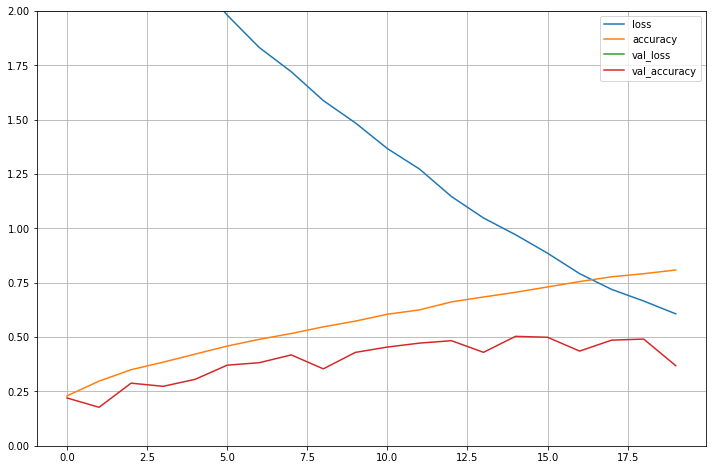

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [0]:
model.evaluate(ds_test)

157/157 [==============================] - 5s 33ms/step - loss: 3.3091 - accuracy: 0.3688


[3.3090856075286865, 0.36880001425743103]

## Customiser ce que se passe dans `fit()`

### Les étapes cachées dans `.fit()`

```python
class CustomModel(keras.Model):

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(x, training=True)
      loss = self.compiled_loss(y, y_pred,
                                regularization_losses=self.losses)

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}
```

1. On récupère les données du minibatch :

```python 
  def train_step(self, data):
    x, y = data
```

Le type de données que vous récupérez dépend évidemment du type de modèle que vous entraînez et donc des données que vous passez dans `.fit()`.

```python
    with tf.GradientTape() as tape:
```
`tf.GradientTape()` est la méthode de Tensorflow pour différentier les fonctions, i.e. calculer des dérivées et des dérivées partielles. Qui dit dérivées partielles, dit étapes de mises à jours des poids. 


2. On calcule la prédiction sur le minibatch :
$$(\hat{y}_{1}, \dots, \hat{y}_{N}) =( f(x_{1}), \dots, f(x_{N})) $$
```python
      y_pred = self(x, training=True)
```

3. Pour chaque $\hat{y}_{i}$, on calcule l'erreur faite via la fonction de perte $\mathcal{L}_{\vartheta}(y_{i},\hat{y}_{i})$, et on en déduit l'erreur moyenne sur le minibatch.

$$\mathcal{L}_{\vartheta} = \frac{1}{N}\sum_{i=1}^{N}\mathcal{L}_{\vartheta}(y_{i},\hat{y}_{i})$$

```python
      loss = self.compiled_loss(y, y_pred,
                                regularization_losses=self.losses)
```

On rappelle que la fonction de perte est définie dans la `.compile()`. 

4. On calcule alors le gradient pour chaque paramètre dans $\vartheta$, i.e.

$$\nabla \mathcal{L}_{\vartheta}$$
```python
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
```

5. On met alors à jour les paramètres :

$$ w_{i} \leftarrow w_{i} - \eta \frac{\partial \mathcal{L}_{\vartheta}}{\partial w_{i}}(\vartheta), \\
b_{i} \leftarrow b_{i} - \eta \frac{\partial \mathcal{L}_{\vartheta}}{\partial b_{i}}(\vartheta).$$
```python
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
```

6. On met alors à jour les métriques (loss, accuracy, ...) et on renvoit un dictionnaire contenant ces mise à jours.

```python
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}
```

Voyons un peu comment se comportent ses différentes étapes.

Inutile de lancer ça sur un vrai modèle, plusieurs centaines de couches et millions de paramètres. Nous voulons d'abord juste voir comme nt cela fonctionne. Créons donc un dataset et un modèle complètement naïf.

In [0]:
class CustomModel(keras.Model):

  def train_step(self, data):
    print()
    print(f"----Etape: {self.step_counter}")
    self.step_counter += 1
    
    x, y = data
    print(f'Début du train : {x.shape}, {y.shape}')

    with tf.GradientTape() as tape:
      print(f'Start GradientTape step {x.shape}')
      y_pred = self(x, training=True)
      print(f'Prediction done {y_pred.shape}')
      loss = self.compiled_loss(y, y_pred,
                                regularization_losses=self.losses)
      print(f'loss {loss}')

    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

In [0]:
#Créons un dataset dummy
t_x = tf.random.uniform([30, 4], dtype=tf.float32)
t_y = tf.range(30)

ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)

ds = tf.data.Dataset.zip((ds_x, ds_y))

ds = ds.batch(3)

from tensorflow.keras import Model
# Dummy model
input = Input(shape=(4,))

x = Dense(32)(input)
output = Dense(1)(x)

model = CustomModel(input,x)

model.compile(loss = 'mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              run_eagerly=True)
model.step_counter = 0
model.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                160       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(ds,
          epochs=1,
          verbose=0)


----Etape: 0
Start train step (None, 4), (None,)
Start GradientTape step (None, 4)
Prediction done (None, 32)
loss Tensor("mean_absolute_error/weighted_loss/value:0", shape=(), dtype=float32)

----Etape: 1
Start train step (None, 4), (None,)
Start GradientTape step (None, 4)
Prediction done (None, 32)
loss Tensor("mean_absolute_error/weighted_loss/value:0", shape=(), dtype=float32)


Pas très concluant hein ? on ne voit même pas toutes les étapes. C'est parce que Python est un langage lent, la plupart des structure internes de Tensorflow sont codés dans un langage beaucoup plus rapide tel que le C ou le C++.

Ce que l'on écrit n'est dont pas toujours ce que l'on obtient vraiment. Pour que `tf.keras` fasse les instructions de façon séquentielle, on complie le modèle en rajoutant l'option :

```python
run_eagerly=True
```

In [0]:
model.compile(loss = 'mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              run_eagerly=True)
model.step_counter = 0
model.summary()

model.fit(ds,
          epochs=1,
          verbose=0)

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                160       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________

----Etape: 0
Start train step (3, 4), (3,)
Start GradientTape step (3, 4)
Prediction done (3, 32)
loss 1.0454397201538086

----Etape: 1
Start train step (3, 4), (3,)
Start GradientTape step (3, 4)
Prediction done (3, 32)
loss 3.949005126953125

----Etape: 2
Start train step (3, 4), (3,)
Start GradientTape step (3, 4)
Prediction done (3, 32)
loss 6.941404342651367

----Etape: 3
Start train step (3, 4), (3,)
Start GradientTape step (3, 4)
Prediction done (3, 32)
loss 9.953435897827148

----Etape: 4
Start train ste

### Prise en main de `GradientTape`

`GradientTape` enregistre les opérations qui sont faites dans un graphe (voir rappel du module 1 sur comment une fonction peut se définir comme une graphe), afin de calculer la différentielle de cette fonction.

Prenons un exemple simple, la fonction $f(x) = x^{2}$, on souhaite calculer sa dérivée en 3. Les formules classiques d'analyse différentielle nous donnent alors $f'(x)=2x$ et donc $f'(3)=6$.

Avec `GradientTape`, on fait comme cela.

In [0]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x

dy_dx = tape.gradient(y, x)

In [0]:
dy_dx

Dans le cas de `tf.keras`, la partie `tape.watch(x)` qui nous dit par rapport à quelle variable nous allons dériver n'est pas nécessaire, `tf.keras` sait très bien quels sont les paramètres dans le réseau de neurones que nous entraînons.

On peut évidemment le combiner pour calculer des dérivées secondes.

In [0]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  with tf.GradientTape() as tape2:
    tape2.watch(x)
    y = x * x
  dy_dx = tape2.gradient(y, x)     
d2y_dx2 = tape.gradient(dy_dx, x)

In [0]:
dy_dx

In [0]:
d2y_dx2

### We need to go deeper

Dans les modules suivants nous verrons comment modifier la méthode  `.fit()` pour qu'elle corresponde à l'entraînement que l'on souhaite, par exemple lorque l'on entraînera un autoencodeur variationnel.

Il faut aussi noter que l'on peut complètement écrire sa boucle d'entraînement sans passer en aucune façon par la méthode `.fit()`. Ce qui est pratique, voire même nécéssaire si l'on souhaite implémenter certaines bonnes pratiques lors de l'entraînement de certains modèles comme les GAN.

```python
epochs = ...
loss_fn = tf.keras.losses.[..]
metric_fn = tf.keras.metrics.[...]
optimizer = tf.keras.optimizers.[...]

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    #prédiction sur le minibatch
    y_pred = model(x, training=True)
    #calcul de la fonction de perte moyenne sur le minibatch
    loss_value = loss_fn(y, y_pred)

  # calcul des gradients et retropropagation
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # mise à jour des métriques
  metric_fn.update_state(y, y_pred)

  return loss_value

@tf.function
def test_step(x, y):
  y_pred = model(x, training=False)
  loss_value = loss_fn(y, y_pred)
  metric_fn.update_state(y, y_pred)

  return loss_value

for epoch in range(epochs):
  print(f"\nDébut de l'époque {epoch+1},")
  start_time = time.time()

  # itération sur les minibatchs du dataset
  for step, (x_batch_train, y_batch_train) in enumerate(ds):
    loss_value = train_step(x_batch_train, y_batch_train)

    # Log tous les 10 batches
    if step % 10 == 0:
      print(f"Loss sur le batch à l'étape {step} : {float(loss_value):.4f}")

  # Affichage des métriques à la fin de l'époque
  metric = metric_fn.result()
  print(f"Métrique pour l'époque : {float(metric):.4f} \n")
    
  # Reset de la métrique à la fin de chaque époque
  metric_fn.reset_states()

  # validation loop à la fin de chaque époque
  for x_batch_val, y_batch_val in ds_val:
    val_loss = test_step(x_batch_val, y_batch_val)

  val_metric = metric_fn.result()
  metric_fn.reset_states()
  print()
  print(f"Loss de validation : {float(val_loss):.4f}")
  print(f"Métrique de validation : {float(val_metric):.4f}")
  print(f"Durée de l'époque: {time.time() - start_time:.2fs}")
```

Détaillons les parties importantes.

- On lance une boucle `for` pour itérer sur les époques.
- Pour chaque époque, on ouvre une autre boucle `for`
 pour itérer sur les batchs du dataset.
- Pour chaque batch, on ouvre un `GradientTape()`, où l'on calcule l'étape de feedforward.
- Une fois fini, on calcule le gradient par rapport aux poids du modèle et l'on met à jour ces poids.

Détaillons plus. Il est à noter ici que pour cette boucle, nous avons déjà accès aux batchs. Notre dataset est donc déjà sous la forme tensorielle via, l'API `tf.data.Dataset`.


Premièrement, on fixe les variables : le nombre d'époques, et les différents fonctions que l'on utilisera. 
```python
epochs = ...
loss_fn = tf.keras.losses.[..]
metric_fn = tf.keras.metrics.[...]
optimizer = tf.keras.optimizers.[...]
```

On lance alors la boucle principale sur le nombre d'époque.
```python
for epoch in range(epochs):
  print(f"\nDébut de l'époque {epoch+1},")
  start_time = time.time()
```

Pour chaque batch, on lance alors l'étape d'entraînement (on revient dessus plus tard) et on affiche la perte disons par exemple tous les 10 minibatchs.
```python
for step, (x_batch_train, y_batch_train) in enumerate(ds):
    loss_value = train_step(x_batch_train, y_batch_train)

    # Log tous les 10 batches
    if step % 10 == 0:
      print(f"Loss sur le batch à l'étape {step} : {float(loss_value):.4f}")
```

Une fois que tous les minibatchs sont passés, l'époque est finie. On affiche alors la métrique moyenne obtenue à la fin.
```python
  # Affichage des métriques à la fin de l'époque
  metric = metric_fn.result()
  print(f"Métrique pour l'époque : {float(metric):.4f} \n")
```

On remet à zéro la métrique pour le début de la nouvelle époque.
```python
  # Reset de la métrique à la fin de chaque époque
  metric_fn.reset_states()
```

Si on souhaite  avoir un dataset de validation, c'est ici que ça se passe. Comme pour `train_step`, on y revient bientôt.
```python
  # validation loop à la fin de chaque époque
  for x_batch_val, y_batch_val in ds_val:
    val_loss = test_step(x_batch_val, y_batch_val)
```

On affiche les métriques de validation.
```python
  val_metric = metric_fn.result()
  metric_fn.reset_states()
  print()
  print(f"Loss de validation : {float(val_loss):.4f}")
  print(f"Métrique de validation : {float(val_metric):.4f}")
  print(f"Durée de l'époque: {time.time() - start_time:.2fs}")
```


Comme expliqué plus haut, `tf.keras` a en fait deux modes de fonctionnement, et le fonctionnement de base est celui dit `eager mode`, ce qui fait que les instructions données dans une fonctions définie à la main, comme ici pour `def train_step`, seront exécutées les unes à la suites des autres, ce qui est long.

Le décorateur `@tf.function` permet de transformer toute fonction n'yant come variable que des tenseurs en un **graphe statique**. Il n'est pas nécessaire d'en savoir plus sur ces fameux graphes, la seule chose à savoir est que cela **augmente la vitesse à laquelle les opérations sont faites dans la fonction**.

En dehors de cela, la fonction `train_step` est **exactement la même que celle définie dans `.fit()`, de la même façon pour la fonction de validation**.

```python
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    #prédiction sur le minibatch
    y_pred = model(x, training=True)
    #calcul de la fonction de perte moyenne sur le minibatch
    loss_value = loss_fn(y, y_pred)

  # calcul des gradients et retropropagation
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # mise à jour des métriques
  metric_fn.update_state(y, y_pred)

  return loss_value
```

```python
@tf.function
def test_step(x, y):
  y_pred = model(x, training=False)
  loss_value = loss_fn(y, y_pred)
  metric_fn.update_state(y, y_pred)

  return loss_value
```

## Callbacks

En plus des arguments classiques tel que `epochs` ou `validation_data`, la méthode `.fit()` accepte aussi l'argument `callbacks`. Les callbacks permettent de fournir une **liste** d'intruction que `tf.keras` à certains moment précis de l'entraînement : 

- au début (à la fin) de l'époque actuelle,
- au début (à la fin de l'étape de minibatch actuelle,
- au début (à la fin) de l'entraînement.

Nous avons déjà vu le callback `LearningRateScheduler` dans le module suivant lorsque nous parlions du Learninf Rate Decay. L'idée est ici de passer en revue les plus importants, et de voir la structure interne d'un callback pour en écrire un nous même.

### Les callbacks importants

#### `tf.keras.callbacks.EarlyStopping`

`EarlyStopping` permet à `tf.keras` d'aretter de lui même l'entraînement. On lui passe la métrique que l'on souhaite monitorer, et les crières d'arrêts.

On l'appelle vec les paramètres suivants.

```python
keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=1e-2,
                              patience=10,
                              verbose=1)
```

Détaillons.

```python
keras.callbacks.EarlyStopping(monitor='val_loss',
```
Détermine la métrique à surveillez, principalement la `val_loss`, mais on peut aussi monitorer `val_acc`, ou les métriques d'entraînement. Ici, l'entraînement s'arette lorsque `val_loss` ne s'améliore plus.

```python
                 min_delta=1e-2,
```

On précise le "ne s'améliore plus" : on dit que la val_loss ne s'améliore plus si

$$\mathrm{val \_loss}(t+1) - \mathrm{val\_loss}(t) \leq 10^{-2}.$$

```python    
                 patience=10,
                 verbose=1)
```

Si pendant 10 époques ça ne s'améliore pas, on arêtte l'entraînement. 

#### `tf.keras.callbacks.ModelCheckpoint`


`ModelCheckpoint` permet lui de faire des sauvegarde régulière du modèle suivant un critère de métrique. Une nouvelle version du modèle ne sera enrégistrée que si la métrique s'est améliorée.

```python
keras.callbacks.ModelCheckpoint('./weights.{epoch:02d}-{val_loss:02d}.h5',
                                                 monitor='val_loss',
                                                 verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='auto',
                                                 save_freq='epoch')
```                                                 

#### `tf.keras.callbacks.LearningRateScheduler`

```python
def exponential_decay(lr0,step):
    def exponential_decay_fn(epoch):
        return lr0*0.1**(epoch/step)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = lr0, step = 20)

keras.callbacks.LearningRateScheduler(exponential_decay_fn)
```

#### `tf.keras.callbacks.TensorBoard`

```python
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
```

```python
%tensorboard --logdir logs
```

```python
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
#Control TensorBoard display. If no port is provided, 
#the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000)
```

```python
callbacks_fit = [keras.callbacks.EarlyStopping(
                 # Stop training when `val_loss` is no longer improving
                 monitor='val_loss',
                 # "no longer improving" being defined as "no better than 1e-2 less"
                 min_delta=1e-2,
                 # "no longer improving" being further defined as "for at least 2 epochs"
                 patience=10,
                 verbose=1),
                 keras.callbacks.LearningRateScheduler(exponential_decay_fn),
                 keras.callbacks.ModelCheckpoint('./weights.{epoch:02d}-.hdf5',
                                                 monitor='val_loss',
                                                 verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='auto',
                                                 save_freq='epoch')]
```

### Structure interne d'un callback

Ce sont tous des sousclasses de la classe `tf.keras.callbacks.Callback`.

On peut les passer en liste lorsque l'on fait appel à l'une des 3 commandes suivantes.

```python
   model.fit()
   model.evaluate()
   model.predict()
```

Un callback fait une action particulière avec une étape particulière, pour définir cette étape on a les méthodes suivantes.

- Méthodes globales
```python
on_(train|test|predict)_begin(self, logs=None)
```
```python
on_(train|test|predict)_end(self, logs=None)
```

- Batch-level méthodes
```python
on_(train|test|predict)_batch_begin(self, batch, logs=None)
```
```python
on_(train|test|predict)_batch_end(self, batch, logs=None)
```
Ici, logs est un dictionnaire contenant les différentes métriques.

- Epoch-level méthodes (uniquement durant lentraînement)
```python
on_epoch_begin(self, epoch, logs=None)
```
```python
on_epoch_end(self, epoch, logs=None)
```

In [0]:
#Créons un dataset dummy
t_x = tf.random.uniform([30, 4], dtype=tf.float32)
t_y = tf.range(30)

ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)

ds = tf.data.Dataset.zip((ds_x, ds_y))

ds = ds.batch(3)

from tensorflow.keras import Model
# Dummy model
input = Input(shape=(4,))

x = Dense(32)(input)
output = Dense(1)(x)

model = Model(input,x)

model.compile(loss = 'mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['mean_absolute_error'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


In [0]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print(f"Début de l'entraînement, les clés du log sont: {keys}")

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print(f"Fin de l'entraînement, les clés du log sont: {keys}")

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print(f"Début de l'époque {epoch}, les clés du log sont: {keys}")

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print(f"Fin de l'époque {epoch}, les clés du log sont: {keys}")

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print(f"Entraînement : début du batch {batch}, les clés du log sont: {keys}")

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print(f"Entraînement : fin du batch {batch}, les clés du log sont: {keys}")


In [0]:
history = model.fit(ds,
                    epochs=1,
                    verbose=0,
                    callbacks=[CustomCallback()])

Début de l'entraînement, les clés du log sont: []
Début de l'époque 0, les clés du log sont: []
Entraînement : début du batch 0, les clés du log sont: []
Entraînement : fin du batch 0, les clés du log sont: ['loss', 'mean_absolute_error']
Entraînement : début du batch 1, les clés du log sont: []
Entraînement : fin du batch 1, les clés du log sont: ['loss', 'mean_absolute_error']
Entraînement : début du batch 2, les clés du log sont: []
Entraînement : fin du batch 2, les clés du log sont: ['loss', 'mean_absolute_error']
Entraînement : début du batch 3, les clés du log sont: []
Entraînement : fin du batch 3, les clés du log sont: ['loss', 'mean_absolute_error']
Entraînement : début du batch 4, les clés du log sont: []
Entraînement : fin du batch 4, les clés du log sont: ['loss', 'mean_absolute_error']
Entraînement : début du batch 5, les clés du log sont: []
Entraînement : fin du batch 5, les clés du log sont: ['loss', 'mean_absolute_error']
Entraînement : début du batch 6, les clés du l

Allons plus dans le détail et voyons par exemple de quelles façons sont calculées les métriques données par `tf.keras`. 

In [0]:
class LossCallback(tf.keras.callbacks.Callback):
  
    def on_train_batch_end(self, batch, logs):
        print(f'Batch {batch}, la perte est de {logs["loss"]:.2f}.\n')

    def on_epoch_end(self, epoch, logs):
        print(f'La perte moyenne pour lépoque {epoch} est {logs["loss"]:.2f} \n')

cb = LossCallback()

In [0]:
history = model.fit(ds,
                    epochs=1,
                    verbose=0,
                    callbacks=[cb])

Batch 0, la perte est de 1.01.

Batch 1, la perte est de 2.46.

Batch 2, la perte est de 3.93.

Batch 3, la perte est de 5.41.

Batch 4, la perte est de 6.90.

Batch 5, la perte est de 8.40.

Batch 6, la perte est de 9.89.

Batch 7, la perte est de 11.39.

Batch 8, la perte est de 12.89.

Batch 9, la perte est de 14.39.

La perte moyenne pour lépoque 0 est 14.39 



La façon dont `tf.keras` calcule la fonction de perte à la fin de de chaque époque est donc en faisant une moyenne : à la fin de l'époque, la métrique de perte donnée est **la perte moyenne sur un minibatch**, et à la fin de chaque batch, la métrique de perte donnée est la **perte moyenne mouvante**.

Si l'on souhaite avoir la perte moyenne sur une observation, ou la valeur de la perte sur chaque batch, comment faire ?

$$\mathrm{AvgLoss}_{n+1} := \frac{\mathrm{Loss}_{n+1}+n\cdot \mathrm{AvgLoss}_{n}}{n+1}$$

$$(n+1)\cdot\mathrm{AvgLoss}_{n+1} -n\cdot \mathrm{AvgLoss}_{n} = \mathrm{Loss}_{n+1}$$

In [0]:
class LossCallback(tf.keras.callbacks.Callback):

    def __init__(self, L = 0):
        self.L = L
  
    def on_train_batch_end(self, batch, logs):
      if batch == 0:
        print(f'Batch {batch}, loss is {logs["loss"]:.2f}.\n')
        #logs['loss'] gives the running avg mean, not the mean of the minibatch
      else:
        print(f'Batch {batch}, loss is {(batch+1)*logs["loss"]-self.L:.2f}.\n')
        print(f'Batch {batch}, running loss is {logs["loss"]:.2f}.\n')
      self.L = (batch+1)*logs["loss"]

    def on_epoch_end(self, epoch, logs):
        print(f'Avg loss on {epoch} is {logs["loss"]:.2f} \n')

cb = LossCallback()

model.fit(ds,
          epochs=1,
          verbose=0,
          callbacks=[cb])

Batch 0, loss is 0.95.

Batch 1, loss is 3.78.

Batch 1, running loss is 2.36.

Batch 2, loss is 6.73.

Batch 2, running loss is 3.82.

Batch 3, loss is 9.71.

Batch 3, running loss is 5.29.

Batch 4, loss is 12.72.

Batch 4, running loss is 6.78.

Batch 5, loss is 15.75.

Batch 5, running loss is 8.27.

Batch 6, loss is 18.74.

Batch 6, running loss is 9.77.

Batch 7, loss is 21.78.

Batch 7, running loss is 11.27.

Batch 8, loss is 24.76.

Batch 8, running loss is 12.77.

Batch 9, loss is 27.69.

Batch 9, running loss is 14.26.

Avg loss on 0 is 14.26 



In [0]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs):
    print(f'\n Validation-Train Ratio : {logs["val_loss"]/logs["loss"]:.2f}')

cb = PrintValTrainRatioCallback()

## Annexe

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import random

print(tf.__version__)
print(keras.__version__)

RANDOM_SEED = 42


random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



#dummy dataset
t_x = tf.random.uniform([30, 4], dtype=tf.float32)
t_y = tf.range(30)
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)
ds = tf.data.Dataset.zip((ds_x, ds_y))
ds = ds.batch(3)

class LossCallback(tf.keras.callbacks.Callback):
  
    def on_train_batch_end(self, batch, logs):
        print(f'Batch {batch}, loss is {logs["loss"]:.2f}.\n')
        #logs['loss'] gives the running avg mean, not the mean of the minibatch

    def on_epoch_end(self, epoch, logs):
        print(f'Avg loss on {epoch} is {logs["loss"]:.2f} \n')

cb = LossCallback()

from tensorflow.keras import Model

input = Input(shape=(4,))

x = Dense(2)(input)
X = Dense(1)(x)

model = Model(input,x)

model.compile(loss = 'mean_absolute_error',
              optimizer=tf.keras.optimizers.SGD())

history = model.fit(ds,
                    epochs=1,
                    verbose=0,
                    callbacks=[cb])

2.2.0
2.3.0-tf
Batch 0, loss is 0.83.

Batch 1, loss is 2.00.

Batch 2, loss is 3.40.

Batch 3, loss is 4.83.

Batch 4, loss is 6.27.

Batch 5, loss is 7.75.

Batch 6, loss is 9.21.

Batch 7, loss is 10.71.

Batch 8, loss is 12.20.

Batch 9, loss is 13.67.

Avg loss on 0 is 13.67 

